# Applying some basic machine learning to the culled dataset of amino acid distances and antigenic distances


In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import linear_model as sklm
from sklearn import svm
from sklearn import ensemble
from sklearn import grid_search
import plotly.plotly as py
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures


Populating the interactive namespace from numpy and matplotlib


In [2]:
DATAFILE = 'antigenic-genetic-pret8-positional-no-0-and-upto-10-mutations.csv'

In [3]:
from regressiondata import RegressionData

ImportError: No module named 'regressiondata'

In [ ]:
data = RegressionData(DATAFILE, dropFirstRow=True)
df = data.df

In [ ]:
splitData = data.splitByYear(1994)

In [ ]:
train = splitData['train']
X = splitData['X']

### Checking the distribution of the data
The data are dominated by strains from the early 1990s

In [13]:
x = list(data.df['strain_1_dates'])

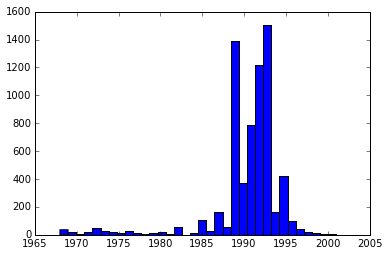

In [16]:
_ = plt.hist(x, bins=35)

KeyError: 0

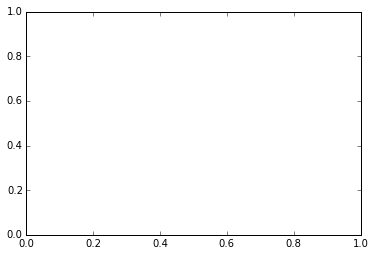

In [9]:
_ = plt.hist(df['strain_1_dates'], bins = 35)

KeyError: 0

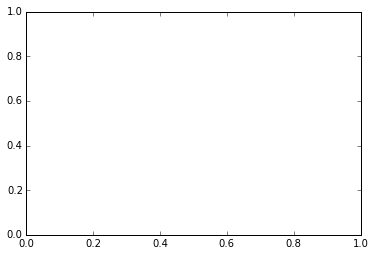

In [17]:
plt.hist(df['strain_2_dates'], bins = 35)

In [52]:
#Creating a dataset with interaction terms
iX = df.drop(['AG1', 'AG2', 'AG-DIST', 'NUM-MUTATIONS', 
                   'strain_1_dates', 'strain_2_dates', 'cluster1', 'cluster2'], axis = 1)
for col1 in X.columns:
    for col2 in X.columns:
        if col1<col2:
            if max(iX[col1]*iX[col2]) >0:
                iX['%s:%s' %(col1, col2)] = (iX[col1]*iX[col2])
    

In [ ]:
ixtrain = iX.loc[((df['strain_1_dates']<=1994)& (df['strain_2_dates'] <=1994))]
ixtest = iX.loc[((df['strain_1_dates']>1994) |(df['strain_2_dates'] >1994))]


In [ ]:
hdtest = np.array(test['NUM-MUTATIONS']).reshape(-1,1)
hdtrain = train['NUM-MUTATIONS']
hdtrain=np.array(hdtrain).reshape(-1,1)
print(hdtrain.shape)

hdxtrain = train.drop(['AG1', 'AG2', 'AG-DIST', 
                       'strain_1_dates', 'strain_2_dates', 'cluster1', 'cluster2'], axis = 1)
hdxtrain['NUM-MUTATIONS'] = train['NUM-MUTATIONS']
hdxtest = test.drop(['AG1', 'AG2', 'AG-DIST',
                     'strain_1_dates', 'strain_2_dates', 'cluster1', 'cluster2'], axis = 1)


In [20]:
cvlist = data.cv(train, 'cluster1', 'cluster2')

In [ ]:
for tple in cvlist:
    assert set(tple[0]).isdisjoint(tple[1])

### Checking that the training and test data are disjoint
Looks good

In [ ]:
fig_size = [8, 4]
plt.rcParams["figure.figsize"] = fig_size
 
plt.hist((train[['strain_1_dates', 'strain_2_dates']].max(axis=1)), bins=range(1960,2004))
figure(2)
plt.hist((train[['strain_1_dates', 'strain_2_dates']].max(axis=1)), bins=range(1960,2004))
plt.hist((test[['strain_1_dates', 'strain_2_dates']].max(axis=1)), bins=range(1960,2004), color = 'g')


#### Here's a function to plot the coefficients of a linear model

In [ ]:
def coefplot(coefs, cutoff = 0.01, interaction = False):
    fig_size = [20, 10]
    plt.rcParams["figure.figsize"] = fig_size
    if interaction:
        params = pd.DataFrame(data = coefs, index = ixtrain.columns)
    else:
        params = pd.DataFrame(data = coefs, index = xtrain.columns)
    
    params = params.loc[(params[0]<-cutoff)|(params[0]>cutoff)]
    params = params.sort_values(0)
    fig, ax = plt.subplots()
    x = range(len(params.index))
    ax.scatter(x, list(params[0]), color="g", s=10)
    xticks(x, x)
    ax.set_xlim([-1, len(params)])
    
    ax.set_xticklabels(["\n".join(list(name)) for name in params.index],
                       fontsize=10)

### Let's have a look at how far apart in years the antigenic distance comparisons we have are


In [ ]:
fig_size = [6, 3]
plt.rcParams["figure.figsize"] = fig_size

plt.hist(df['strain_2_dates']-df['strain_1_dates'], bins = range(16))

### What is the distribution of antigenic distances?


In [ ]:
fig_size = [6, 3]
plt.rcParams["figure.figsize"] = fig_size

plt.hist(df['AG-DIST'], bins = 32)

In [ ]:
def errorplot(clf, xtst):
    fig_size = [15, 6]
    plt.rcParams["figure.figsize"] = fig_size

    errors = ytest.to_frame()
    errors['ytest'] = ytest
    errors['predicted'] = clf.predict(xtst)
    errors['error'] = errors['ytest']-errors['predicted']
    errors['date'] = test['strain_2_dates']
    errors = errors.sort_values('error')
    #plt.figure(1)
    #plt.scatter(range(len(ytest)), errors['error'])
    #plt.xlim(0, len(ytest)+1)
    
    #plt.figure(2)
    #plt.scatter(range(len(ytest)), errors['ytest'], color = 'g')
    #plt.scatter(range(len(ytest)), errors['predicted'])
    #plt.scatter(range(len(ytest)), errors['error'], color = 'r')
    
    plt.figure(3)
    errors = errors.sort_values('date')
    errors['jittered_dates'] = errors['date'] + np.random.uniform(-2, 2, len(test))
    plt.scatter(errors['jittered_dates'], errors['ytest'], color = 'g')
    plt.scatter(errors['jittered_dates'], errors['predicted'], color = 'b')
    plt.scatter(errors['jittered_dates'], errors['error'], color = 'r')
    
    plt.figure(4)
    plt.hist(errors['error'])

### Now we try fitting various ml models

In [ ]:
clf=sklm.LinearRegression()
clf.fit(xtrain, ytrain)
score=clf.score(xtest, ytest)
print(score)

Oh dear, that didn't work very well. Let's have a look at the coefficients.

In [ ]:
coefplot(clf.coef_)

It looks like quite a few of the coefficients are quite strongly negative, and most of them are zero

### As a baseline, how well can we do with just Hamming Distances?

In [ ]:
hdclf=sklm.LinearRegression()
hdclf.fit(hdtrain, ytrain)
score=hdclf.score(hdtest, ytest)
print(score)

This is better than Oskar's model.
Anything below an r^2 of 0.55 is worse than just counting the number of mutations

In [ ]:
fig_size = [15, 15]
plt.rcParams["figure.figsize"] = fig_size
jitteredHD = df['NUM-MUTATIONS'] + np.random.uniform(-0.3, 0.3, len(df))
plt.xlabel('NUM-MUTATIONS')
plt.ylabel('AG-DIST')
plt.scatter(jitteredHD, df['AG-DIST'])
plt.xlim(0,26)
plt.ylim(0,17)

In [ ]:
errorplot(hdclf, hdtest)

### Now let's try a regularized linear regression

In [ ]:
scores1 = []
for a in [0.01, 0.1, 1, 10 , 100, 1000, 1500, 2000, 3000]:
    clf1 = sklm.Ridge(alpha = a)
    clf1.fit(xtrain, ytrain)
    scores1.append(clf1.score(xtest, ytest))
print(scores1)

In [ ]:
scores1 = []
scores2 = []
for a in [5, 10, 20, 40, 80, 100, 200, 300, 400]:
    clf1 = sklm.Ridge(alpha = a)
    clf1.fit(xtrain, ytrain)
    scores1.append(clf1.score(xtest, ytest))
    scores2.append(clf1.score(xtrain,ytrain))
print(scores1)

print('The fit on the training data is')
print(scores2)


In [ ]:
clf = sklm.Ridge(alpha = 300)
clf.fit(xtrain,ytrain)
clf.score(xtest, ytest)

#### Let's see what the errors look like

In [ ]:
errorplot(clf, xtest)

In [ ]:
coefplot(clf.coef_)

### What happens if we include hamming distance in the model?

In [ ]:

scores1 = []
for a in [5, 10, 20, 40, 80, 100, 200, 300, 400]:
    clf1 = sklm.Ridge(alpha = a)
    clf1.fit(hdxtrain, ytrain)
    scores1.append(clf1.score(hdxtest, ytest))
print(scores1)

Seems like accuracy is slightly worse but basically the same. The errors look pretty similar, maybe a tiny bit better around the extremes

### Let's try a lasso penalised regression, and force the coefficients to be positive

In [ ]:
scores =[]
for a in [0.001, 0.005, 0.008, 0.009, 0.01, 0.015, 0.05, 0.1, 1]:
    clf1 = sklm.Lasso(alpha = a, positive=True)
    clf1.fit(xtrain, ytrain)
    scores.append(clf1.score(xtest, ytest))
print(scores)


In [ ]:
clf = sklm.Lasso(alpha = 0.015, positive=True)
clf.fit(xtrain, ytrain)
clf.score(xtest, ytest)

In [ ]:
coefplot(clf.coef_, True)
plt.figure(2)
coefplot(clf.coef_, False)

### Let's try including the interaction terms in a lasso model

In [ ]:
iscores =[]
for a in [0.001, 0.005, 0.008, 0.009, 0.01, 0.015, 0.05, 0.1, 1]:
    iclf = sklm.Lasso(alpha = a, positive=True)
    iclf.fit(ixtrain, ytrain)
    iscores.append(iclf.score(ixtest, ytest))
print(iscores)

In [ ]:
iscores =[]
for a in [0.01, 0.015, 0.05, 0.1, 0.2, 0.3]:
    iclf = sklm.Lasso(alpha = a)
    iclf.fit(ixtrain, ytrain)
    iscores.append(iclf.score(ixtest, ytest))
print(iscores)

In [ ]:
iclf = sklm.Lasso(alpha = 0.1 )
iclf.fit(ixtrain, ytrain)
iclf.score(ixtest, ytest)

In [ ]:
coefplot(iclf.coef_, True, True)
plt.figure(2)

In [ ]:
def getcoefs(coefs, omitsmall = True):
    cfs = pd.DataFrame(data = coefs, index = ixtrain.columns)
    if omitsmall:
        cfs = cfs.loc[(cfs[0]<-0.1)|(cfs[0]>0.1)]
    cfs = cfs.sort_values(0)
    return cfs


The distances for the 3 interaction terms (from right to left) are 52.3, 26.8 and 14.9. 

52.3 is too far apart to be a plausible distance, but 26.8 and 14.9 seem to be valid interaction terms

Let's find out whether DE190 and NT276 ever occur apart

In [ ]:
print(sum(ixtrain['NT276']))
print(sum(ixtrain['DE190']))
print(sum(ixtrain['NT276'] & (ixtrain['DE190'])))
print(sum(ixtrain['NT276'] & ~(ixtrain['DE190'])))
print(sum(~(ixtrain['NT276']) & (ixtrain['DE190'])))

In [ ]:
getcoefs(iclf.coef_)

### Let's try using interaction terms with a ridge model

In [ ]:
iscores =[]
for a in [0.01, 0.1, 1, 10, 100, 1000]:
    iclf = sklm.Ridge(alpha = a)
    iclf.fit(ixtrain, ytrain)
    iscores.append(iclf.score(ixtest, ytest))
print(iscores)

In [ ]:
iscores =[]
for a in [100, 1000, 2000, 5000, 10000]:
    iclf = sklm.Ridge(alpha = a)
    iclf.fit(ixtrain, ytrain)
    iscores.append(iclf.score(ixtest, ytest))
print(iscores)

In [ ]:
iclf = sklm.Ridge(alpha = 5000 )
iclf.fit(ixtrain, ytrain)
iclf.score(ixtest, ytest)

In [ ]:
coefplot(iclf.coef_, cutoff=0.1, interaction=True)

This model has far too many terms and gets a worse fit than using the ridge model without interaction terms - I guess it's overfitting

### Let's try using support vector machines!

In [ ]:
clf2 = svm.SVR()
clf2.fit(xtrain, ytrain)
svmscore=clf2.score(xtest, ytest)
print(svmscore)

In [ ]:
errorplot(clf2, xtest)

### These are pretty slow. Let's try random forests

In [ ]:
num = [10, 50, 200, 500, 1000]
depth= [5,10, 12, 15, 20, 30, 40]
scores=np.empty([len(depth)+1, len(num)+1])
scores[0,1:] = num
scores[1:,0] = depth

In [ ]:
for i in range(len(num)):
    for j in range(len(depth)):
        clf3 = ensemble.RandomForestRegressor(n_estimators=num[i], max_depth=depth[j])
        clf3.fit(xtrain, ytrain)
        rfscore=clf3.score(xtest, ytest)
        scores[j+1][i+1]=rfscore
print(scores)


The scores are significantly worse than the linear model. 

In [ ]:
num2 = [5, 10, 15, 20, 30, 40]
maxlf= [10, 50, 100, 200, 500]
scores2=np.empty([len(maxlf)+1, len(num2)+1])
scores2[0,1:] = num2
scores2[1:,0] = maxlf

In [ ]:
for i in range(len(num2)):
    for j in range(len(maxlf)):
        clf3 = ensemble.RandomForestRegressor(n_estimators=num2[i], max_leaf_nodes=maxlf[j])
        clf3.fit(xtrain, ytrain)
        rfscore=clf3.score(xtest, ytest)
        scores2[j+1][i+1]=rfscore
print(scores2)

In [ ]:
clf4 = ensemble.RandomForestRegressor(n_estimators=11, max_leaf_nodes=100)
clf4.fit(xtrain, ytrain)
rfscore2=clf4.score(xtest, ytest)
print(rfscore2)

In [ ]:
coefplot(clf4.feature_importances_)

In [ ]:
errorplot(clf4, xtest)

The errors here are pretty skewed towards overestimating the distances - interesting

In [ ]:
lolo = LeaveOneLabelOut(train['cluster1'])
cvscores = cross_val_score(clf4, xtrain, ytrain, cv = lolo)
print(cvscores)


In [ ]:
train.cluster1.value_counts().plot(kind='bar', color = 'b')
train.cluster2.value_counts().plot(kind='bar', color = 'g')
print(train.cluster1.shape)
print(train.cluster2.shape)

In [ ]:
customcvscores = cross_val_score(clf4, xtrain, ytrain, cv = cvlist)
print(customcvscores)

In [ ]:
scores3=np.empty([7,6])
cvar = [0.01, 0.1, 1, 10, 100]
epsilonvar= [0.001, 0.01, 0.1, 1, 10, 100]
scores3[0,1:] = cvar
scores3[1:,0] = epsilonvar

In [ ]:
for i in range(5):
    for j in range(6):
        clf5 = svm.SVR(C = cvar[i], epsilon = epsilonvar[j])
        clf5.fit(xtrain, ytrain)
        svmscore=clf5.score(xtest, ytest)
        scores3[j+1][i+1]=svmscore
print(scores3)

In [ ]:
scores4=np.empty([7,6])
cvar = [0.5, 1, 2, 4, 10]
epsilonvar= [0.001, 0.01, 0.1, 0.5, 1, 2]
scores4[0,1:] = cvar
scores4[1:,0] = epsilonvar

for i in range(5):
    for j in range(6):
        clf5 = svm.SVR(C = cvar[i], epsilon = epsilonvar[j])
        clf5.fit(xtrain, ytrain)
        svmscore=clf5.score(xtest, ytest)
        scores4[j+1][i+1]=svmscore
print(scores4)

In [ ]:
with open('svm scores grid 2', 'w') as f:
    f.write(repr(scores4))

In [ ]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

print(scores4)

In [ ]:
scores5=np.empty([6,3])
cvar = [0.5,10]
epsilonvar= [0.5, 0.8, 1, 1.2, 1.4]
scores5[0,1:] = cvar
scores5[1:,0] = epsilonvar

for i in range(2):
    for j in range(5):
        clf5 = svm.SVR(C = cvar[i], epsilon = epsilonvar[j])
        clf5.fit(xtrain, ytrain)
        svmscore=clf5.score(xtest, ytest)
        scores5[j+1][i+1]=svmscore
print(scores5)

In [ ]:

n_estimators = [5, 10, 20, 25, 30, 35]
learnrate= [0.01, 0.1, 1, 10, 15, 20, 40]
ABscores=np.empty([len(learnrate)+1, len(n_estimators)+1])
ABscores[0,1:] = n_estimators
ABscores[1:,0] = learnrate


for i in range(len(learnrate)):
    for j in range(len(n_estimators)):
        ABclf = sk.ensemble.AdaBoostRegressor(n_estimators=n_estimators[j], learning_rate=learnrate[i])
        ABclf.fit(xtrain, ytrain)
        ABscores[i+1,j+1] = ABclf.score(xtest, ytest)
        
print(ABscores)


In [ ]:
n_estimators = [5, 10, 20, 25, 30, 35]
learnrate= [0.1, 1, 2, 5]
ABscores=np.empty([len(learnrate)+1, len(n_estimators)+1])
ABscores[0,1:] = n_estimators
ABscores[1:,0] = learnrate


for i in range(len(learnrate)):
    for j in range(len(n_estimators)):
        ABclf = sk.ensemble.AdaBoostRegressor(n_estimators=n_estimators[j], learning_rate=learnrate[i])
        ABclf.fit(xtrain, ytrain)
        ABscores[i+1,j+1] = ABclf.score(xtest, ytest)
        
print(ABscores)

In [ ]:
ABclf = sk.ensemble.AdaBoostRegressor(n_estimators=30, learning_rate=0.1)
ABclf.fit(xtrain, ytrain)
ABclf.score(xtest, ytest)

In [ ]:
coefplot(ABclf.feature_importances_, cutoff = 0.01)

In [ ]:
n_estimators = [5, 10, 20, 25, 30, 35]
learnrate= [0.1, 1, 2, 5]
ABscores=np.empty([len(learnrate)+1, len(n_estimators)+1])
ABscores[0,1:] = n_estimators
ABscores[1:,0] = learnrate


for i in range(len(learnrate)):
    for j in range(len(n_estimators)):
        ABclf = sk.ensemble.AdaBoostRegressor(n_estimators=n_estimators[j], learning_rate=learnrate[i])
        ABclf.fit(ixtrain, ytrain)
        ABscores[i+1,j+1] = ABclf.score(ixtest, ytest)
        
print(ABscores)

In [24]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Grid search with 10-fold cross-validation using a dictionary of parameters

# Create the dictionary of given parameters
n_estimators = [5, 10, 20, 40, 80]
learnrate= [0.01, 0.1, 1, 10]
parameters  = [{'n_estimators': n_estimators, 'learning_rate': learnrate}] 

# Optimise and build the model with GridSearchCV
gridCV = grid_search.GridSearchCV(ensemble.AdaBoostRegressor(), parameters, cv=cvlist)
# print(gridCV)
gridCV.fit(xtrain, ytrain) 

# Report the optimal parameters
bestNeighbors = gridCV.best_params_['n_estimators']
bestWeight    = gridCV.best_params_['learning_rate']

print("Best parameters: n_estimators=", bestNeighbors, "and learnrate=", bestWeight)


/Users/terry/.virtualenvs/lm35/lib/python3.5/site-packages/sklearn/base.py:176: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() instead

/Users/terry/.virtualenvs/lm35/lib/python3.5/site-packages/sklearn/base.py:176: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() instead

/Users/terry/.virtualenvs/lm35/lib/python3.5/site-packages/sklearn/base.py:176: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() instead

/Users/terry/.virtualenvs/lm35/lib/python3.5/site-packages/sklearn/base.py:176: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() instead

/Users/terry/.virtualenvs/lm35/lib/python3.5/site-packages/sklearn/base.py:176: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() instead

/Users/terry/.virtualenvs/lm35/lib/python3.5/site-packages/sklearn/utils/validation.py:531: DeprecationWarning:

inspect.getargspec() is deprecated, u